Counting dry spells in precipitation data
=========================================

## What is a dry spell?


#### **A dry spell** is a period in which every pentad (5 days period) receives a precipitation amount < 5mm


Alternative definitions exist: **a)** A pentad (5 days period) that receives a precipitation < 5mm.
**b)** A pentad (5 days period) or more that receives an average precipitation < 1mm per day
**c)** A period of 5 or more days, in which each day receives <1mm precipitation. Some definitions use a minimum period of 3 days instead of 5 days.

## Example
Consider the precipitation pattern

```
0 0 0 2 2 0 2 0 1 0
```
* With **Our Definition** this pattern counts one dry spell of length 6. Then, we go on to look for the next dry spell from day 7.

```
         0 0 0 2 2 0 2 0 1 0
         v v v v v                      (dry spell)
           v v v v v                    (dry spell)
             x x x x x                  (wet spell)

```


* With **Definition a** this pattern counts two dry spells (dry pentads).
With this definition, one studies the length of dry spells in terms of consecutive dry pentads.
* With **Definition b** the same pattern counts one dry spell of length 10.
Also, both the patterns `0 0 0 0 2 0 2 2 2` and `0 0 0 0 0 0 0 0 5 4` count one dry spell of length 10 altough they both contain a wet pentad.
* With **Definition c** this pattern counts no dry spell.


## Implementation with Python + xarray

### I - Prerequiste

#### **Compute pentad precipitation**
Suppose we have a daily precipitation data `ds_precip_daily` with dimensions `(day, lat, lon)` with `day = 365 or 366` for a year. We make a copy of it that stores pentad precipitation.
```
ds_precip_pentad[day=i] = ds_precip_daily[day=(i, i+4)]
``` 

In [30]:
def use_days(data):
    '''Most data have datetime dimensions, change the time dimension into dayofthe year '''
    data_with_days = data.assign_coords(day=precip['time.dayofyear'])
    data_with_days = data_with_days.swap_dims({'time': 'day'})
    return data_with_days

def pentad(precip):
    precip = use_days(precip)
    pentad_precip = xr.zeros_like(precip)
    for t0 in range(1, precip.day.size+1-4):  # assume 
        pentad_precip.loc[dict(day=t0)] = precip.loc[dict(day=slice(t0,t0+4))].sum(dim='day')
    pentad_precip = pentad_precip.swap_dims({'day': 'time'})
    return pentad_precip

In [31]:
import xarray as xr
import numpy as np
file = 'gpcc-precipitation-madagascar-2000.nc'
ds_disk = xr.open_dataset(file)
precip = ds_disk['precip']
precip_pentad = pentad(precip)

#### **Mark dry pentads**
Now we transform our `pentad_precip` data into 0s or 1s depending on whether the precipitation of the pentad is less than the threshold. 

In [32]:
thresh = 5
dry_pentad = xr.where(precip_pentad<thresh, 1, 0)

#### **Find dry spells**
To find the dry spells, we are going to work at a point (lat, lon) (not sure if a better method exists).
For example if at a given (lat, lon) starting from day 1, 
* if dry_pentads[1:13]= 1 1 0 1 0 0 0 0 0 0 0 0: dry spell of length 6 from day 1
* if dry_pentads[1:13]= 0 1 1 1 0 0 0 0 0 0 0 0: dry spell of length 7 from day 2
* if dry_pentads[1:13]= 0 1 0 1 0 0 0 1 0 0 0 0: dry spells of length 5 from day 2 and from day 8


**Stack** transform (lat, lon) into a single two-dimensional dimension

In [33]:
stacked_precip = precip.stack(z=('lon', 'lat'))
stacked_dry_pentad = dry_pentad.stack(z=('lon', 'lat'))
stacked_precip = precip.stack(z=('lon', 'lat'))
stacked_dry_pentad = dry_pentad.stack(z=('lon', 'lat'))
stacked_dry_pentad = stacked_dry_pentad.swap_dims({'time': 'day'})

**Algorithm 1** recursively locate the end of a dry spell. The algorithm receives as input, 
* a series of 0s and 1s (dimension: day). `series[time=t_0] = 1` when a dry pentad starts at `t_0`.  
* a day at which a dry spell starts
* the begining and end of the interval where to find the end of the dry spells

Basically the algorithm looks for the longest series of 1s starting from `day_start`

In [92]:
def find_spell_at_interval(series, day_start, begin, end):
    '''look for the end of dry spell at interval, divide and conquer'''
    #pdb.set_trace()
    if end >= series.size:
        return find_spell_at_interval(series, day_start, begin, end-1)
    if end - begin <= 1:
        if series.loc[dict(day=end)] == 1:
            return (end - day_start + 1)
        else:
            return (begin - day_start + 1)
    else:
        mid = ((begin+end)//2)
        if series.loc[dict(day=slice(day_start, mid))].sum() > mid-day_start+0.99: # i.e all ones from day_start to mid
            return find_spell_at_interval(series, day_start, mid, end)
        else:
            return find_spell_at_interval(series, day_start, begin, mid)


**Algorithm** skip the points (x,y) outside region, the precipitation data of these are all 0s. We also skip each day which is not the start of a dry pentad.

In [ ]:
dry_spell = xr.zeros_like(stacked_dry_pentad)

for xy in dry_spell.z:
    series = stacked_dry_pentad.loc[dict(z=xy)]
    day_start = 1
    while day_start <= dry_spell.day.size-thresh+1:
        if stacked_precip.loc[dict(z=xy)].sum(dim='time') < thresh:   # for xy outside region, all zero, eliminate them
            print("outside")
            break
        wet = False
        if stacked_dry_pentad.loc[dict(day=day_start,z=xy)] == 0:
            day_start += 1
            wet = True
        elif  stacked_dry_pentad.loc[dict(z=xy, day=slice(day_start, day_start+19))].sum(dim='day') >= 19.5:
            spell_len = find_spell_at_interval(series, day_start, day_start+19, dry_spell.day.size+1)
            print("above 20 for day_start=", day_start, spell_len)
        else:
            spell_len = find_spell_at_interval(series, day_start, day_start+4, day_start+19)
            print("below 20 for day_start=", day_start, spell_len)
        if not wet:
            dry_spell.loc[dict(day=day_start,z=xy)] = spell_len
            day_start += spell_len
dry_spell = dry_spell.unstack().swap_dims({'day': 'time'})
dry_spell.name = 'spells'
dry_spell_zeros_ones = xr.where(dry_spell > 4, 1, 0)
print(dry_spell.sum(dim='time').values)


In [37]:
dspells = dry_spells(precip, thresh)


array([0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 0,
       4, 4, 4, 0, 0, 0, 4, 5, 4, 5, 5, 4, 4, 5, 4, 4, 4, 3, 0, 0, 0, 4,
       0, 5, 4, 4, 4, 4, 4, 3, 3, 2, 3, 3, 0, 0, 5, 0, 5, 5, 3, 4, 4, 4,
       4, 3, 4, 3, 3, 0, 0, 0, 0, 5, 5, 5, 5, 3, 3, 4, 4, 4, 3, 3, 4, 5,
       0, 6, 0, 0, 0, 3, 3, 3, 4, 2, 3, 3, 4, 4, 5, 4, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 3, 3, 3, 4, 4, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

#### **COMBINING INTO ONE FUNCTION**
and return an xarray data 2D (lat, lon) for one year, with dry_spell.frequency (number of dry spells) and dry_spell.average_length

In [ ]:
import xarray as xr
import numpy as np
from tqdm import tqdm
file = 'gpcc-precipitation-madagascar-2000.nc'
file = 'interpolated-chirps-v2-region-2000.nc'
ds_disk = xr.open_dataset(file)
precip = ds_disk['precip']
thresh = 5

def use_days(data):
    '''Most data have datetime dimensions, change the time dimension into dayofthe year '''
    data_with_days = data.assign_coords(day=precip['time.dayofyear'])
    data_with_days = data_with_days.swap_dims({'time': 'day'})
    return data_with_days

def pentad(precip):
    precip = use_days(precip)
    pentad_precip = xr.zeros_like(precip)
    for t0 in range(1, precip.day.size+1-4):  # assume 
        pentad_precip.loc[dict(day=t0)] = precip.loc[dict(day=slice(t0,t0+4))].sum(dim='day')
    return pentad_precip

def find_spell_at_interval(series, day_start, begin, end):
    '''look for the end of dry spell at interval, divide and conquer'''
    #pdb.set_trace()
    if end > series.size:
        return find_spell_at_interval(series, day_start, begin, end-1)
    if end - begin <= 1:
        if series.loc[dict(day=end)] == 1:
            return (end - day_start + 1)
        else:
            return (begin - day_start + 1)
    else:
        mid = ((begin+end)//2)
        if series.loc[dict(day=slice(day_start, mid))].sum() > mid-day_start+0.99: # i.e all ones from day_start to mid
            return find_spell_at_interval(series, day_start, mid, end)
        else:
            return find_spell_at_interval(series, day_start, begin, mid)
        
def dry_spells(precip):
    precip_pentad = pentad(precip)    
    dry_pentad = xr.where(precip_pentad<thresh, 1, 0)
    stacked_precip = precip.stack(z=('lat', 'lon'))
    stacked_dry_pentad = dry_pentad.stack(z=('lat', 'lon'))
    dry_spell = xr.zeros_like(stacked_dry_pentad)
    stacked_precip = precip.stack(z=('lat', 'lon'))
    stacked_dry_pentad = dry_pentad.stack(z=('lat', 'lon'))
    #stacked_dry_pentad = stacked_dry_pentad.swap_dims({'time': 'day'})
    for xy in tqdm(dry_spell.z):
        series = stacked_dry_pentad.loc[dict(z=xy)]
        day_start = 1
        while day_start <= dry_spell.day.size-thresh+1:
            if stacked_precip.loc[dict(z=xy)].sum(dim='time') < thresh:   # for xy outside region, all zero, eliminate them
                break
            wet = False
            if stacked_dry_pentad.loc[dict(day=day_start,z=xy)] == 0:
                day_start += 1
                wet = True
            elif  stacked_dry_pentad.loc[dict(z=xy, day=slice(day_start, day_start+19))].sum(dim='day') >= 19.5:
                spell_len = find_spell_at_interval(series, day_start, day_start+19, dry_spell.day.size+1)
            else:
                spell_len = find_spell_at_interval(series, day_start, day_start+4, day_start+19)
            if not wet:
                dry_spell.loc[dict(day=day_start,z=xy)] = spell_len
                day_start += spell_len
    dry_spell = dry_spell.unstack().swap_dims({'day': 'time'})
    dry_spell_len_sum = dry_spell.sum(dim='time')
    dry_spell_zeros_ones = xr.where(dry_spell > 4, 1, 0)
    dry_spell_count = dry_spell_zeros_ones.sum(dim='time')
    dry_spell_count.name = 'freq'
    dry_spell_len_ave = xr.where(dry_spell_count>0.5, dry_spell_len_sum/dry_spell_count, 0)
    dry_spell_len_ave.name = 'average_len'
    dry_spell = xr.merge([dry_spell_count, dry_spell_len_ave])
    return dry_spell
    
chirps_spells = dry_spells(precip)

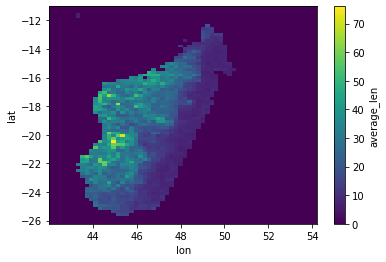

In [97]:
chirps_spells.average_len.plot()

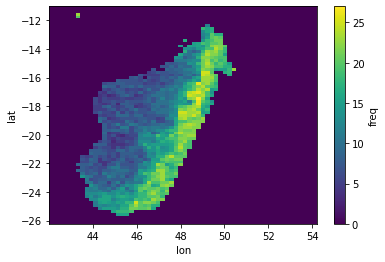

In [98]:
chirps_spells.freq.plot()